# Counting Chocolate Chips in Chocolate Chip Cookies
Explore the dataset. It contains training cookies, and labels.

In [26]:
import os

training_images_dir = os.path.join('./dataset/images')

The cookies are images. Let's see what the first ten filenames look like, and display to total number of images in that directory:

In [27]:
print('Examples: ', os.listdir(training_images_dir)[:10])
print('Total number of training images:', len(os.listdir(training_images_dir)))

Examples:  ['legacy 8.jpg', 'regular 30 34.jpg', 'regular 29 15.jpg', 'regular 32 19.jpg', 'regular 30 23.jpg', 'regular 32 32.jpg', 'regular 32 26.jpg', 'chunky 28 34.jpg', 'chunky 27 58.jpg', 'regular 32 09.jpg']
Total number of training images: 62


Display one of the cookies:

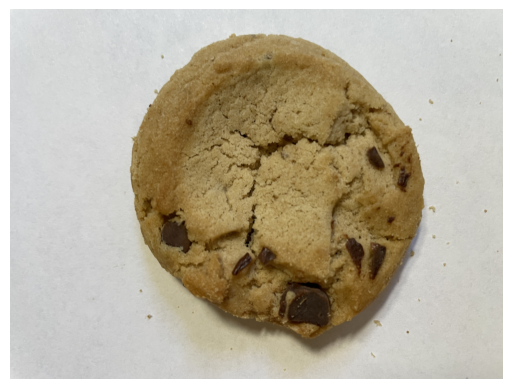

In [28]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img

chunky_cookie_img = load_img('./dataset/images/chunky 28 34.jpg')

plt.imshow(chunky_cookie_img)
plt.axis('off')
plt.show()

The labels are numbers. The label indicates the number of visible chocolate chips in that cookie. Indicating the correct number of chocolate chips in a cookie is difficult for a number of reasons:
* some chocolate chips are only `partially` visible.
* some chocolate chips are `divided` by dough and appear as two individual chocolate chips.
* sometimes chocolate chips `smear` off on other cookies.

In [29]:
import pandas as pd

training_labels_file = './dataset/labels/labels.csv'
training_labels_data_frame = pd.read_csv(training_labels_file)

# Print the first 10 labels
print('Examples: ', training_labels_data_frame['label'].head(10).to_list())

Examples:  [6, 6, 7, 8, 8, 3, 8, 7, 11, 8]


## Convolutional Neural Network

The ultimate concept is that they narrow down the content of the image to focus on specific parts and this will likely improve the model accuracy. 

If you've ever done image processing using a filter (like [this](https://en.wikipedia.org/wiki/Kernel_(image_processing))), then convolutions will look very familiar. In short, you take an array (usually 3x3 or 5x5) and scan it over the entire image. By changing the underlying pixels based on the formula within that matrix, you can do things like edge detection. So, for example, if you look at the above link, you'll see a 3x3 matrix that is defined for edge detection where the middle cell is 8, and all of its neighbors are -1. In this case, for each pixel, you would multiply its value by 8, then subtract the value of each neighbor. Do this for every pixel, and you'll end up with a new image that has the edges enhanced.

This is perfect for computer vision because it often highlights features that distinguish one item from another. Moreover, the amount of information needed is then much less because you'll just train on the highlighted features.

That's the concept of **Convolutional Neural Networks**. Add some layers to do convolution before you have the dense layers, and then the information going to the dense layers is more focused and possibly more accurate.

Run the code below. This is the same neural network as earlier, but this time with [Convolution](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers added first. It will take longer, but look at the impact on the accuracy.

Look at the code again, and see, step by step how the convolutions were built. Instead of the input layer at the top, you added a [Conv2D layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). The parameters are:

1. The number of convolutions you want to generate. The value here is purely arbitrary but it's good to use powers of 2 starting from 32.
2. The size of the Convolution. In this case, a 3x3 grid.
3. The activation function to use. In this case, you used a ReLU, which you might recall is the equivalent of returning `x` when `x>0`, else return `0`.
4. In the first layer, the shape of the input data.

You'll follow the convolution with a [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layer which is designed to compress the image, while maintaining the content of the features that were highlighted by the convolution. By specifying `(2,2)` for the MaxPooling, the effect is to quarter the size of the image. Without going into too much detail here, the idea is that it creates a 2x2 array of pixels, and picks the biggest one. Thus, it turns 4 pixels into 1. It repeats this across the image, and in doing so, it halves both the number of horizontal and vertical pixels, effectively reducing the image to 25% of the original image.

We feed the images into the convolutions, and flatten the final result to feed into the densely connected layers. Note that we count the number of chocolate chips, i.e. the final output is a scalar.

### What is the optimal number of convolutional layers?
We have tried with three, four or five convolutional layers. Four layers produces the best result.

| Number of layers | Loss | Mean abs. err. |
|------------------|------|----------------|
| 3                | 7.2  | 2.1            |
| 4                | 5.0  | 1.8            |
| 5                | 9.0  | 2.5            |

CNN vs. MobileNetV2.

| Number of layers | Loss | Mean abs. err. |
|------------------|------|----------------|
| CNN              | 0.7  | 0.7            |
| MobileNetV2      | 1.4  | 0.9            |

In [30]:
import tensorflow as tf
# from tensorflow.keras.applications import MobileNetV2

# base_model = MobileNetV2(
#     input_shape=(300, 300, 3), 
#     include_top=False, 
#     weights='imagenet'
# )
# base_model.trainable = False

model = tf.keras.models.Sequential([
    # base_model,
    # tf.keras.layers.GlobalAveragePooling2D(),
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    tf.keras.layers.Input(shape=(300, 300, 3)),
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # Single output for the count of chocolate chips
    tf.keras.layers.Dense(1) 
])

| Dropout       | Loss | Mean abs. err. |
|---------------|------|----------------|
| 0.2           | 1.2  | 0.8            |
| 0.3           | 1.3  | 0.9            |
| 0.5           | 1.0  | 0.8            |
| 0.6           | 2.4  | 1.3            |

You can review the network architecture and the output shapes with model.summary().

In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,450,145 (32.23 MB)

 Trainable params: 8,450,145 (32.23 MB)

 Non-trainable params: 0 (0.00 B)

To build a model in TensorFlow that takes images of cookies as inputs and counts the number of chocolate chips in them, you can use a Convolutional Neural Network (CNN). This type of network is well-suited for image processing tasks. The output layer of the model should be a single neuron since we're predicting a single scalar value (the count of chocolate chips).

We will train the model with the [`mean_squared_error`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError) loss because we measure absolute loss.  (For a refresher on loss metrics, see this [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) You will use the [`adam`](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) optimizer. A sophisticated form of SGD, it automatically adapts the learning rate during training. You will want to monitor the mean absolute error.

In [32]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer='adam',  # Adam optimizer
    loss='mean_squared_error',  # Mean squared error for regression
    metrics=['mean_absolute_error'])  # Mean absolute error as a metric

### Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to `float32` tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras, this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)`, `.flow_from_directory(directory)`, or `.flow_from_dataframe(df)`.

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd

def load_dataset(images_dir, labels_file, target_size=(300, 300), batch_size=10):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(labels_file)
    
    # Create an ImageDataGenerator
    datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.2  # 20% of data for validation
    )

    # Create the train and validation generators
    training_generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=images_dir,
        x_col='filename',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',  # Use 'raw' to get labels as they are in the CSV
        subset='training'
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=images_dir,
        x_col='filename',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',  # Use 'raw' to get labels as they are in the CSV
        subset='validation'
    )
    
    return training_generator, validation_generator

# Create generators
training_generator, validation_generator = load_dataset(training_images_dir, training_labels_file)

Found 50 validated image filenames.
Found 12 validated image filenames.



| Batch size       | Loss | Mean abs. err. |
|------------------|------|----------------|
| 10               | 1.1  | 0.8            |
| 8                | 5.0  | 1.8            |
| 5                | 5.3  | 1.8            |
| 2                | 2.4  | 1.3            |

Some batch sizes work better than others. It's a little unclear why. Smaller batch sizes probably over-fit.

| # of neurons     | Loss | Mean abs. err. |
|------------------|------|----------------|
| 128 (fastest)    | 9.1  | 2.2            |
| 256              | 6.8  | 2.1            |
| 512              | 4.4  | 1.7            |
| 1024 (slowest)   | 4.5  | 1.6            |

The number of neurons in the hidden layer impacts training speed and accuracy. Diminishing returns, and possibly over-fitting.

## Creating a Callback class

You can create a callback by defining a class that inherits the [`tf.keras.callbacks.Callback`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) base class. From there, you can define available methods to set where the callback will be executed. For instance below, you will use the [`on_epoch_end()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback#on_epoch_end) method to check the loss at each training epoch.

In [34]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when the loss falls below 0.8

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the loss
    if(logs.get('loss') < 0.8):

      # Stop if threshold is met
      print("\nLoss is lower than 0.8 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

### Training

You can start training for 15 epochs -- this may take a few minutes to run. Increasing the number of epochs reduces the model loss.

| Epochs           | Loss | Mean abs. err. |
|------------------|------|----------------|
| 10               | 6.1  | 2.1            |
| 15               | 4.6  | 1.6            |
| 20               | 2.7  | 1.2            |
| 50               | <0.8 | <0.7           |
| 100              | <0.7 | <0.6           |
| 1000             | <0.5 | <0.6           |

Do note the values per epoch.

The `loss` and `mean_absolute_error` are great indicators of progress in training. `loss` measures the current model prediction against the known labels, calculating the result. `mean_absolute_error`, on the other hand, is the deviation from the correct number of chocolate chips.

`model.fit` seems to remember what has been trained, so unless you re-define and re-compile the model it continues to train the same model. Cumulatively.

In [35]:
history = model.fit(
      training_generator,
      validation_data=validation_generator,
      epochs=10, #50,
      verbose=1,
      callbacks=[callbacks])

/Users/svend/.pyenv/versions/3.12.7/envs/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 35.7226 - mean_absolute_error: 4.5945 - val_loss: 44.5864 - val_mean_absolute_error: 6.2850
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 13.9118 - mean_absolute_error: 3.2829 - val_loss: 15.5114 - val_mean_absolute_error: 3.4934
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 6.5318 - mean_absolute_error: 2.1532 - val_loss: 11.3793 - val_mean_absolute_error: 3.0052
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 7.2795 - mean_absolute_error: 2.1135 - val_loss: 18.4044 - val_mean_absolute_error: 3.7838
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 5.0876 - mean_absolute_error: 1.8352 - val_loss: 9.7842 - val_mean_absolute_error: 2.7845
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 7.6344 - mean_absolute_error: 2.1032 - val_loss: 10.0022 - val_mean_absolute_error: 2.8050
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 6.1371 - mean_absolute_error: 1.8519 - val_loss: 11.4492 - val_m

# Visualizing the Convolutions and Pooling

Let's explore how to show the convolutions graphically. The cell below prints the first 100 labels in the test set, and you can see that the ones at index `0`, index `23` and index `28` are all the same value (i.e. `9`). They're all shoes. Let's take a look at the result of running the convolution on each, and you'll begin to see common features between them emerge. Now, when the dense layer is training on that data, it's working with a lot less, and it's perhaps finding a commonality between shoes based on this convolution/pooling combination.

NameError: name 'training_image' is not defined

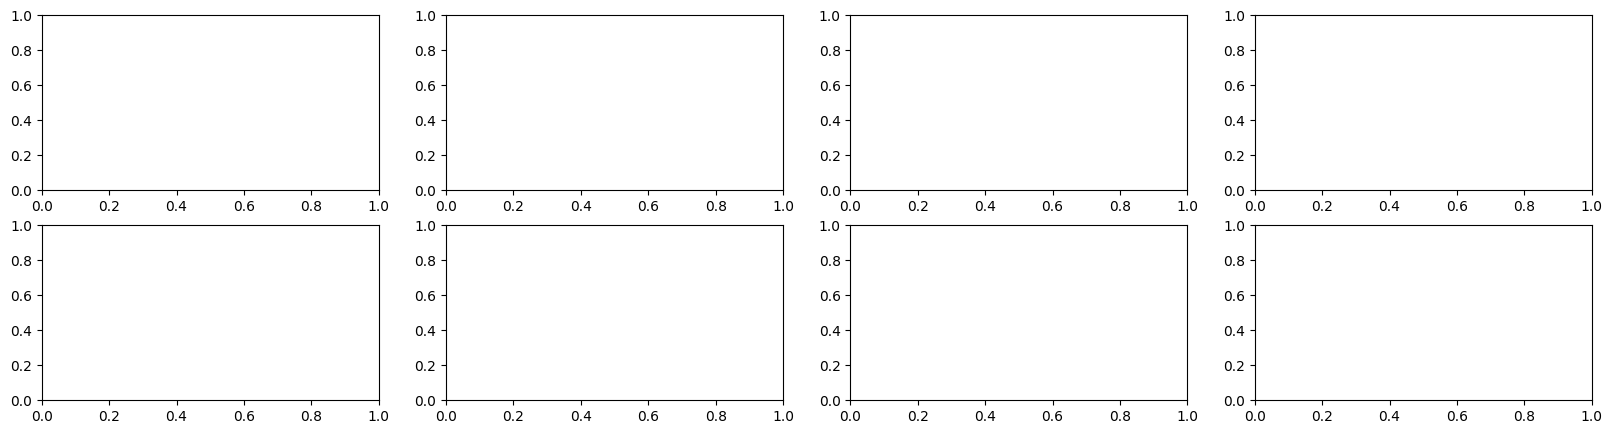

In [45]:
import matplotlib.pyplot as plt
# from tensorflow.keras import models


# Optionally, call the model with some dummy data
# dummy_input = tf.random.normal((1, 300, 300, 3))  # Shape should match your input shape
# model(dummy_input)  # This will make the model see the input shape

f, axarr = plt.subplots(2, 4, figsize=(20, 5))

# Get the first batch of images and labels
training_images, training_labels = next(training_generator)

FIRST_IMAGE=0
SECOND_IMAGE=3
CONVOLUTION_NUMBER = 7

# Get only the convolutional layer outputs (we don't need pooling, flatten, dense, etc.)
conv_layers = [layer.output for layer in model.layers if 'conv2d' in layer.name]

# Create the activation model with only conv layers
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=conv_layers)

# Get activations
activations = activation_model.predict(training_image)

# Plot activations for each conv layer
for i, activation in enumerate(activations):
    row = i // 4
    col = i % 4
    axarr[row, col].imshow(activation[0, :, :, 0], cmap='viridis')
    axarr[row, col].set_title(f'Conv2D_{i+4}')  # Adding 4 since your layers start at conv2d_4

plt.tight_layout()
plt.show()

# for x in range(0,4):
#   f1 = activation_model.predict(training_images[FIRST_IMAGE].reshape(1, 300, 300, 3))[x]
#   axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
#   axarr[0,x].grid(False)
  
#   f2 = activation_model.predict(training_images[SECOND_IMAGE].reshape(1, 300, 300, 3))[x]
#   axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
#   axarr[1,x].grid(False)


### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

_**Note:** Old versions of the Safari browser might have compatibility issues with the code block below. If you get an error after you select the images(s) to upload, you can consider updating your browser to the latest version. If not possible, please comment out or skip the code block below, uncomment the next code block and run it._

In [ ]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

path = "./prediction.jpg"
img = load_img(path, target_size=(300, 300))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(f"chocolate chips: {classes[0]}")
  
 

### Export

Export the model to an h5 file.

In [ ]:
model.save('model.h5')